In [ ]:
! python -m pip install git+https://github.com/facebookresearch/segment-anything.git
! python -m pip install git+https://github.com/IDEA-Research/GroundingDINO
! pip install diffusers transformers accelerate scipy safetensors

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-24b65lmy
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-24b65lmy
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36590 sha256=4a9e55fbfe42d7195aa6d65dd4c6bf2dd118b63bc5339ae467a7254fce309b06
  Stored in directory: /tmp/pip-ephem-wheel-cache-cy9nnezo/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
  Cloning https://github.com/IDEA-Research/GroundingDINO to /tmp/pip-req-build-wii1l9z1
  Running command git clone --filter=blob:none --quiet https://github.com/IDEA-Research/GroundingDINO /tmp/pip-req-build-wii1l9z1
  Resolved https://github.com/IDEA-Research/GroundingD

In [ ]:
! wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

--2024-04-09 16:58:14--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.96, 3.163.189.51, 3.163.189.108, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   209MB/s    in 15s     

2024-04-09 16:58:29 (167 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



In [ ]:
# reference implementation: https://github.com/IDEA-Research/Grounded-Segment-Anything/blob/main/grounded_sam.ipynb

import argparse
import os
import copy

import numpy as np
import torch
from PIL import Image, ImageDraw, ImageFont
from torchvision.ops import box_convert

# Grounding DINO
import groundingdino.datasets.transforms as T
from groundingdino.models import build_model
from groundingdino.util import box_ops
from groundingdino.util.slconfig import SLConfig
from groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap
from groundingdino.util.inference import annotate, load_image, predict

import supervision as sv

# segment anything
from segment_anything import build_sam, SamPredictor
import cv2
import numpy as np
import matplotlib.pyplot as plt


# diffusers
import PIL
import requests
import torch
from io import BytesIO
from diffusers import StableDiffusionInpaintPipeline


from huggingface_hub import hf_hub_download


def load_model_hf(repo_id, filename, ckpt_config_filename, device='cpu'):
    cache_config_file = hf_hub_download(repo_id=repo_id, filename=ckpt_config_filename)

    args = SLConfig.fromfile(cache_config_file)
    model = build_model(args)
    args.device = device

    cache_file = hf_hub_download(repo_id=repo_id, filename=filename)
    checkpoint = torch.load(cache_file, map_location='cpu')
    log = model.load_state_dict(clean_state_dict(checkpoint['model']), strict=False)
    print("Model loaded from {} \n => {}".format(cache_file, log))
    _ = model.eval()
    return model


def download_image(url, image_file_path):
    r = requests.get(url, timeout=4.0)
    if r.status_code != requests.codes.ok:
        assert False, 'Status code error: {}.'.format(r.status_code)

    with Image.open(BytesIO(r.content)) as im:
        im.save(image_file_path)

    print('Image downloaded from url: {} and saved to: {}.'.format(url, image_file_path))


def show_mask(mask, image, random_color=True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.8])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.cpu().reshape(h, w, 1) * color.reshape(1, 1, -1)

    annotated_frame_pil = Image.fromarray(image).convert("RGBA")
    mask_image_pil = Image.fromarray((mask_image.cpu().numpy() * 255).astype(np.uint8)).convert("RGBA")

    return np.array(Image.alpha_composite(annotated_frame_pil, mask_image_pil))


def load_groundingdino_model():
    ckpt_repo_id = "ShilongLiu/GroundingDINO"
    ckpt_filenmae = "groundingdino_swinb_cogcoor.pth"
    ckpt_config_filename = "GroundingDINO_SwinB.cfg.py"

    return load_model_hf(ckpt_repo_id, ckpt_filenmae, ckpt_config_filename)


def load_sam_model():
    sam_checkpoint = "sam_vit_h_4b8939.pth"
    sam = build_sam(checkpoint=sam_checkpoint)
    sam.to(device="cuda")
    return SamPredictor(sam)


def load_stable_diffusion_pipeline():
    pipe = StableDiffusionInpaintPipeline.from_pretrained(
        "stabilityai/stable-diffusion-2-inpainting",
        torch_dtype=torch.float16,
    )
    return pipe.to("cuda")


def download_and_process_image(url, local_image_path):
    download_image(url, local_image_path)
    return load_image(local_image_path)


def predict_objects(model, image, text_prompt, box_threshold, text_threshold):
    return predict(
        model=model,
        image=image,
        caption=text_prompt,
        box_threshold=box_threshold,
        text_threshold=text_threshold
    )


def annotate_image(image_source, boxes, logits, phrases):
    annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
    return annotated_frame[...,::-1]  # BGR to RGB


def predict_masks(sam_predictor, image_source, boxes):
    sam_predictor.set_image(image_source)

    H, W, _ = image_source.shape
    boxes_xyxy = box_ops.box_cxcywh_to_xyxy(boxes) * torch.Tensor([W, H, W, H])

    transformed_boxes = sam_predictor.transform.apply_boxes_torch(boxes_xyxy, image_source.shape[:2]).to("cuda")
    masks, _, _ = sam_predictor.predict_torch(
        point_coords=None,
        point_labels=None,
        boxes=transformed_boxes,
        multimask_output=False,
    )

    return masks


def inpaint_image(pipe, image, mask, prompt):
    image_inpainting = pipe(prompt=prompt, image=image, mask_image=mask).images[0]
    return image_inpainting

def process_image(groundingdino_model, sam_predictor, image_source, image, text_prompt, box_threshold, text_threshold):
    boxes, logits, phrases = predict_objects(groundingdino_model, image, text_prompt, box_threshold, text_threshold)
    annotated_frame = annotate_image(image_source, boxes, logits, phrases)
    masks = predict_masks(sam_predictor, image_source, boxes)
    annotated_frame_with_mask = show_mask(masks[0][0], annotated_frame)
    image_mask = masks[0][0].cpu().numpy()
    return annotated_frame_with_mask, image_mask


def prepare_images_for_inpainting(image_source, image_mask):
    image_source_pil = Image.fromarray(image_source)
    image_source_for_inpaint = image_source_pil.resize((1024, 1024))
    image_mask_for_inpaint = Image.fromarray(image_mask).resize((1024, 1024))
    return image_source_pil, image_source_for_inpaint, image_mask_for_inpaint


def perform_inpainting(pipe, image_source_pil, image_source_for_inpaint, image_mask_for_inpaint, prompt):
    image_inpainting = inpaint_image(pipe, image_source_for_inpaint, image_mask_for_inpaint, prompt)
    image_inpainting = image_inpainting.resize((image_source_pil.size[0], image_source_pil.size[1]))
    image_inpainting = image_inpainting.resize((1024, 1024))
    image_inpainting = inpaint_image(pipe, image_inpainting, image_mask_for_inpaint, prompt)
    image_inpainting.resize((image_source_pil.size[0], image_source_pil.size[1]))
    return image_inpainting

def save_image(image, file_path):
    image.save(file_path)
    print(f"Image saved to: {file_path}")

def main():
    groundingdino_model = load_groundingdino_model()
    sam_predictor = load_sam_model()
    pipe = load_stable_diffusion_pipeline()

    local_image_path = 'inpaint_demo.jpg'
    url = "https://imageio.forbes.com/specials-images/imageserve/644bcc009fac383fccf1e356/Alejandro-Garnacho-Signs-a-New-Contract-at-Manchester-United/960x0.jpg?format=jpg&width=960"
    image_source, image = download_and_process_image(url, local_image_path)

    TEXT_PROMPT = "face"
    BOX_TRESHOLD = 0.3
    TEXT_TRESHOLD = 0.25

    annotated_frame_with_mask, image_mask = process_image(groundingdino_model, sam_predictor, image_source, image, TEXT_PROMPT, BOX_TRESHOLD, TEXT_TRESHOLD)

    image_source_pil, image_source_for_inpaint, image_mask_for_inpaint = prepare_images_for_inpainting(image_source, image_mask)

    prompt = "lionel messi"
    image_inpainting = perform_inpainting(pipe, image_source_pil, image_source_for_inpaint, image_mask_for_inpaint, prompt)

    # Save the inpainted image to a file
    output_file_path = "inpainted_image.jpg"
    save_image(image_inpainting, output_file_path)

    return image_inpainting


if __name__ == "__main__":
    inpainting = main()


final text_encoder_type: bert-base-uncased
Model loaded from /root/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Image downloaded from url: https://imageio.forbes.com/specials-images/imageserve/644bcc009fac383fccf1e356/Alejandro-Garnacho-Signs-a-New-Contract-at-Manchester-United/960x0.jpg?format=jpg&width=960 and saved to: inpaint_demo.jpg.


SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Image saved to: inpainted_image.jpg


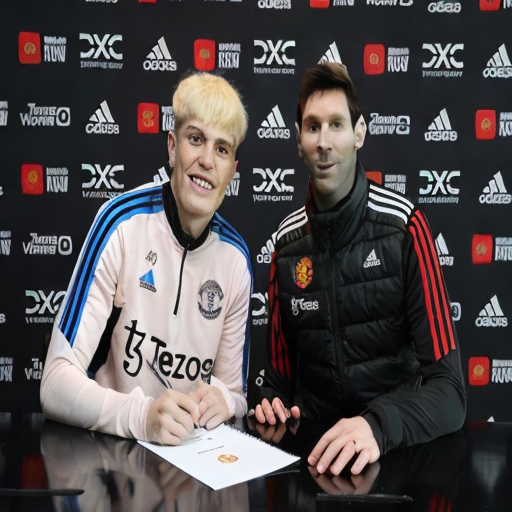

In [ ]:
inpainting

In [ ]:
! pip freeze

NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968